# ASSET demonstration

This notebook aims at showing how to use the ASSET package to extract a spectrum
from log-slit spectroscopy data. This example generates a toy model and then extract the spectrum with several types of PSF.

## Install and load required packages
---

In [1]:
# Install packages to run ASSET
# using Pkg
# pkg"registry add https://github.com/emmt/EmmtRegistry"
# pkg"add https://github.com/SJJThe/InverseProblem"
# pkg"add https://github.com/SlitSpectroscopyBuddies/ASSET.git"

# Install packages for the demo
# pkg"add DelimitedFiles"
# pkg"add PyPlot"

In [2]:
# Load packages
using DelimitedFiles
using PyPlot
using InterpolationKernels
using LinearInterpolators
using InverseProblem
using Statistics

using ASSET

## Generation of a Toy Model
---

The following cells generate a Toy Model to present how to use ASSET.
The spectrum used in the Toy Model was obtained from the P330 E CALSPEC reference spectrum (Bohlin, Gordon & Tremblay 2014). We use a version of this spectrum sampled with 1024 points between 0.5 and 10 microns.
The PSF used in the Toy Model was obtained from the P330 E MIRI LRS data (see Figure 3. and 4. of the paper). We used the two-order non-parametric PSF.
We generate some spatial and spectral coordinate maps align on the grid.

In [3]:
# Interpolation kernel 
ker = CatmullRomSpline(Float64, Flat)

# Get the Toy Model spectrum
lz = readdlm("p330e_for_toymodel.txt");
lz = lz[(lz[:,1].>=4).&&(lz[:,1].<=9),:]
l_tm=lz[:,1]
z_tm=lz[:,2]
λmin=l_tm[1]
λmax=l_tm[end]

Nz=length(z_tm)
# Get the Toy Model PSF and its data
hx=readdlm("nonparametric_parameters_at_order_2.txt")
coord_tm=hx[:,1]
psf_tm=hx[:,2:end] #./ sum(hx[:,2:end], dims=1) #normalize the PSF#FIXME:
shift2=0.7728 # generate an arbitrary shift of the PSF
l_ref = 14.0018 #reference wevelength
order=size(psf_tm)[2]
psf_size=size(psf_tm)[1]

# Generate an arbitrary regularization for the PSF structure
hph=1e0
wh=cat(ones(psf_size,order),zeros(psf_size,order),dims=3)
Rh=WeightedTikhonov(hph, wh);

# Generate a non-parametric PSF of order 2 from the PSF saved 
h_tm=ASSET.SeriesExpansionPSF(psf_tm,range(coord_tm[1],stop=coord_tm[end],length=length(coord_tm)), shift2,ker ,Rh)

SeriesExpansionPSF{Float64, Matrix{Float64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, CatmullRomSpline{Float64, Flat}, WeightedTikhonov{Float64}}([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], -115.0:1.0:115.0, 0.7728, CatmullRomSpline{Float64, Flat}(), Weighted Tikhonov:
 - level `mu` : 1.0
 - weights` : [1.0 1.0; 1.0 1.0; … ; 1.0 1.0; 1.0 1.0;;; 0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0])

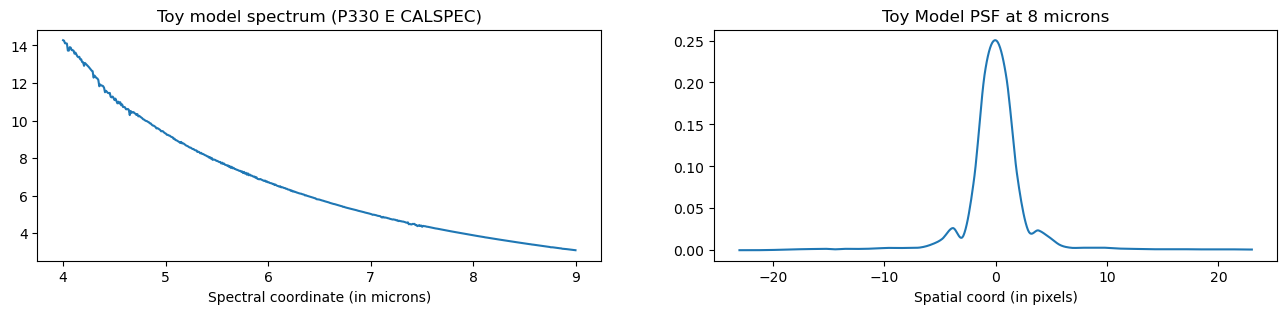

In [4]:
dx=0.1
xx=collect(-23:dx:23)
h_at8=h_tm(xx,8. *ones(length(xx)), λref=λmax)*h_tm[:]
fig, axs = PyPlot.subplots(1,2)
fig.set_size_inches(w=16, h=3)
axs[1].set_title("Toy model spectrum (P330 E CALSPEC)")
axs[1].plot(l_tm,z_tm)
axs[1].set_xlabel("Spectral coordinate (in microns)")
axs[2].set_title("Toy Model PSF at 8 microns")
axs[2].plot(xx, h_at8./(dx*sum(h_at8)))
axs[2].set_xlabel("Spatial coord (in pixels)")
display(gcf())

In [5]:
m = 840 # Number of columns in the data
n = 42  # Number of rows in the data
lambda = repeat(collect(range(λmin, stop=λmax, length=m))', outer=(n,1,2)) # generate a spectral map for two dithers
rho = cat(repeat(collect(range(-n/3, step=1, length=n)), outer=(1,m)),
          repeat(collect(range(-2*n/3, step=1, length=n)), outer=(1,m)), dims=3) #generate spatial map for two dithers


λz=range(λmin, length=Nz, stop=λmax); #Sampling for the spectrum extraction
F = SparseInterpolator(ker, lambda, λz) #Interpolator for the spectrum

H=zeros(n,m,2)
psf_map!(H, h_tm, rho, lambda)
H ./= sum(H,dims=1)
tm=H.*(F*z_tm) .+1e-3

data = tm .+ sqrt.(abs.(tm) .+ 1e-6).*randn(n,m,2) #Generate some data with i.i.d photon noise and some readout noise of var 1e-6
wgt = (rand(n,m,1) .< 0.9)./(abs.(tm) .+ 1e-6) #Generate some weiths as the inverse of the diagonal covariance of the data and with some defective pixels

D = CalibratedData(data, wgt, rho, lambda);

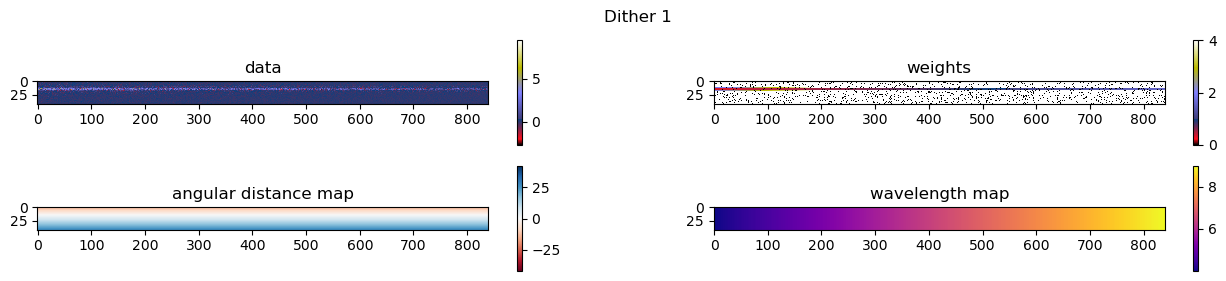

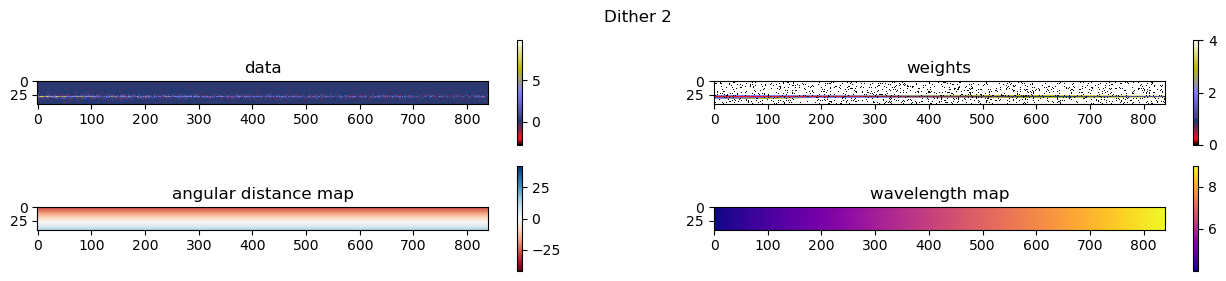

In [6]:
frame = 1
fig, axs = plt.subplots(2,2)
fig.suptitle("Dither $(frame)")
fig.set_size_inches(w=16, h=3)
axs[1,1].set_title("data")
im1 = axs[1,1].imshow(D.d[:,:,frame],cmap="gist_stern", interpolation="none")
fig.colorbar(im1)
axs[1,2].set_title("weights")
im2 = axs[1,2].imshow(D.w[:,:,frame],  cmap="gist_stern", interpolation="none", vmax=4)
fig.colorbar(im2)
axs[2,1].set_title("angular distance map")
im3 = axs[2,1].imshow(D.ρ_map[:,:,frame], cmap="RdBu",vmin=-n, vmax=n)
fig.colorbar(im3)
axs[2,2].set_title("wavelength map")
im4 = axs[2,2].imshow(D.λ_map[:,:,frame],cmap="plasma")
fig.colorbar(im4)
display(gcf())

frame = 2
fig, axs = plt.subplots(2,2)
fig.suptitle("Dither $(frame)")
fig.set_size_inches(w=16, h=3)
axs[1,1].set_title("data")
im1 = axs[1,1].imshow(D.d[:,:,frame],cmap="gist_stern", interpolation="none")
fig.colorbar(im1)
axs[1,2].set_title("weights")
im2 = axs[1,2].imshow(D.w[:,:,frame],  cmap="gist_stern", interpolation="none", vmax=4)
fig.colorbar(im2)
axs[2,1].set_title("angular distance map")
im3 = axs[2,1].imshow(D.ρ_map[:,:,frame], cmap="RdBu",vmin=-n, vmax=n)
fig.colorbar(im3)
axs[2,2].set_title("wavelength map")
im4 = axs[2,2].imshow(D.λ_map[:,:,frame],cmap="plasma")
fig.colorbar(im4)
display(gcf())

## Extractions examples
---

In [7]:
hpz=5e1 #regularization parameter for the spectrum
hpb=1e3  #regularization parameter for the background (reaaaally high because we know it's a scalar background)
Rz=WeightedTikhonov(hpz, ones(Nz,1)) #Spectrum regularization
Rb=hpb*tikhonov() #Background regularization

b=ASSET.BkgMdl(zeros(n,m), Rb) #Background model

BkgMdl{Float64, 2, @NamedTuple{lower::Float64}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], HomogenRegul:
 - level `mu` : 1000.0
 - function `func` : InverseProblem.Tikhonov()
 - use direct inversion `direct_inversion` : true
 - degree `deg` : 2.0, (lower = 0.0,))

### Parametric models


#### Chromatic Gaussian

In [8]:
parinit = maximum(lambda)^(-2)
psf_params_bnds=[(1e-8, 1.)] #The bounds of the gaussian psf parameter for the autocalibration
center_bnds=1. #The bounds of the gaussian center for the autocalibration
h_pg=ASSET.chromGaussianPSF(parinit)
z_pg=zeros(Nz); 

z_fpg,h_fpg =ASSET.extract_spectrum!(z_pg, F, h_pg, D, Rz, b;
                                    auto_calib=Val(true),
                                    max_iter=100,
                                    extract_kwds=(psf_params_bnds=psf_params_bnds,
                                                  psf_center_bnd=center_bnds,
                                                  max_iter=100));

#### Chromatic Moffat

In [9]:
parinit = [h_pg.a, 2.]
psf_params_bnds=[(0., 3.);(1., 3.)]
center_bnds=2.
h_pm=ASSET.chromMoffatPSF(parinit)
z_pm=zeros(Nz)

z_fpm,h_fpm =ASSET.extract_spectrum!(z_pm, F, h_pm, D ,Rz, b;
                                    auto_calib=Val(true),
                                    max_iter=100,
                                    extract_kwds=(psf_params_bnds=psf_params_bnds, 
                                                    psf_center_bnd=center_bnds,
                                                    max_iter=100));

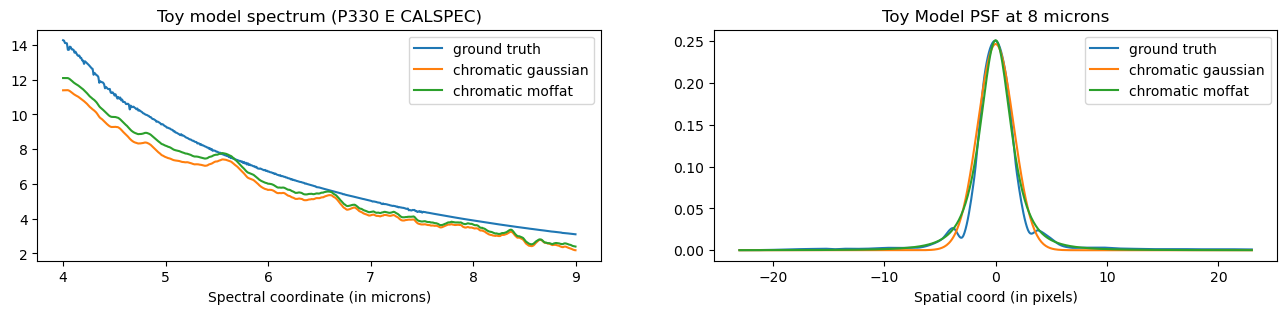

In [10]:
fig, axs = PyPlot.subplots(1,2)
fig.set_size_inches(w=16, h=3)
axs[1].set_title("Toy model spectrum (P330 E CALSPEC)")
axs[1].plot(l_tm,z_tm, label="ground truth")
axs[1].plot(l_tm,z_fpg, label="chromatic gaussian")
axs[1].plot(l_tm,z_fpm, label="chromatic moffat")
axs[1].set_xlabel("Spectral coordinate (in microns)")
axs[1].legend()
axs[2].set_title("Toy Model PSF at 8 microns")
axs[2].plot(xx, h_at8./(dx*sum(h_at8)), label="ground truth")
axs[2].plot(xx, h_fpg.(xx,8. *ones(length(xx))), label="chromatic gaussian")
axs[2].plot(xx, h_fpm.(xx,8. *ones(length(xx))), label="chromatic moffat")
axs[2].set_xlabel("Spatial coord (in pixels)")
axs[2].legend()
display(gcf())

### Non-Parametric PSF

#### Series expansion PSF with one order

In [11]:
order=1

shift_bnds=(-1.,1.)
center_bnds=2.

# Defining the coordinate of the PSF reference plane
gamma=maximum(lambda)./lambda
gamma[lambda .==0] .= 0.
xmin=floor(minimum(gamma.*rho))
xmax=ceil(maximum(gamma.*rho))
x = range(min(xmin,-xmax), 
          stop=max(xmax,-xmin), 
          step=1.)
          
psf_size=length(x)
hph=5e2
wh=cat(ones(psf_size,order),zeros(psf_size,order),dims=3)
Rh=WeightedTikhonov(hph, wh);

h_se1=ASSET.SeriesExpansionPSF(zeros(psf_size,order),x, 0.0,ker ,Rh)

z_se1=copy(z_pm) #initiliaze spectrum with an approximation of the solution to avoid local minima

z_fse1,h_fse1 =ASSET.extract_spectrum!(z_se1, F, h_se1, D ,Rz, b;
            auto_calib=Val(true),
            max_iter=100,
            extract_kwds=(psf_center_bnd=center_bnds,
                          psf_shift_bnds=shift_bnds,
                          max_iter=10));

#Normalization by the PSF area                          
for (i,λk) in enumerate(λz)
    λλ=λk*ones(length(xx))
    HNP = h_fse1(xx,λλ,λref=maximum(lambda))*h_fse1[:]
    z_fse1[i] = z_se1[i]*sum(HNP)*dx
end
  
         

# ITER   EVAL   REJECTS          F(X)           ||G(X)||    STEP
#-----------------------------------------------------------------
     0      1      0    7.2574952085309837E+04  7.64E+04  0.00E+00
    10     13      0    6.3426593235041910E+04  1.40E+04  1.00E+00
    20     23      0    6.3069117636165611E+04  1.28E+04  1.00E+00
    30     34      0    6.3037425026181714E+04  1.06E+03  1.00E+00
    40     45      0    6.3036457681816195E+04  7.54E+01  1.00E+00
# CONVERGENCE: frtol test satisfied
# ITER   EVAL   REJECTS          F(X)           ||G(X)||    STEP
#-----------------------------------------------------------------
     0      1      0    6.3036454308286942E+04  3.54E+01  0.00E+00
# CONVERGENCE: frtol test satisfied
# ITER   EVAL   REJECTS          F(X)           ||G(X)||    STEP
#-----------------------------------------------------------------
     0      1      0    6.3038215794726319E+04  9.51E+00  0.00E+00
    10     12      0    6.3032093303612310E+04  1.58E+01  1.00E

#### Series expansion PSF with two orders

In [12]:
order=2

shift_bnds=(-1.,1.)
center_bnds=2.

hph=1e3
wh=cat(ones(psf_size,order),zeros(psf_size,order),dims=3)
Rh=WeightedTikhonov(hph, wh);

h_se2=ASSET.SeriesExpansionPSF(zeros(psf_size,order),x, 0.0,ker ,Rh)

z_se2=copy(z_pm) #initiliaze spectrum with an approximation of the solution to avoid local minima

z_fse2,h_fse2=ASSET.extract_spectrum!(z_se2, F, h_se2, D ,Rz, b;
            auto_calib=Val(true),
            max_iter=100,
            extract_kwds=(psf_center_bnd=center_bnds,
                          psf_shift_bnds=shift_bnds,
                          max_iter=10));

#Normalization by the PSF area                          
for (i,λk) in enumerate(λz)
    λλ=λk*ones(length(xx))
    HNP = h_fse2(xx,λλ,λref=maximum(lambda))*h_fse2[:]
    z_fse2[i] = z_se2[i]*sum(HNP)*dx
end
  

# ITER   EVAL   REJECTS          F(X)           ||G(X)||    STEP
#-----------------------------------------------------------------
     0      1      0    7.2574814394811430E+04  1.33E+05  0.00E+00
    10     13      0    6.3384661379770085E+04  2.53E+04  1.00E+00
    20     23      0    6.2988721660562165E+04  1.23E+04  1.00E+00
    30     33      0    6.2965446778597056E+04  2.43E+03  1.00E+00
    40     43      0    6.2962246195701307E+04  1.65E+03  1.00E+00
    50     53      0    6.2957504801919735E+04  3.06E+03  1.00E+00
# WARNING: too many iterations
# ITER   EVAL   REJECTS          F(X)           ||G(X)||    STEP
#-----------------------------------------------------------------
     0      1      0    6.2957504801919735E+04  3.06E+03  0.00E+00
    10     15      0    6.2955488293288981E+04  7.47E+02  1.00E+00
    20     26      0    6.2954044788292493E+04  3.65E+03  1.00E+00
    30     36      0    6.2950294335378872E+04  1.88E+03  1.00E+00
    40     47      0    6.294250651

Excessive output truncated after 524418 bytes.

# ITER   EVAL   REJECTS          F(X)           ||G(X)||    STEP
#-----------------------------------------------------------------
     0      1      0    6.0427107522522456E+04  2.48E+01  0.00E+00


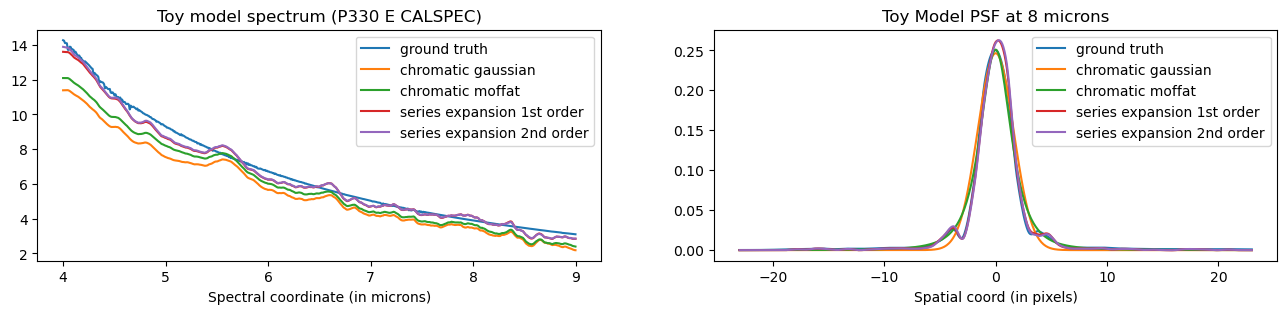

In [13]:
plot_fse1 = h_fse1(xx,8. *ones(length(xx)), λref=λmax)*h_fse1[:]
plot_fse2 = h_fse2(xx,8. *ones(length(xx)), λref=λmax)*h_fse2[:]

fig, axs = PyPlot.subplots(1,2)
fig.set_size_inches(w=16, h=3)
axs[1].set_title("Toy model spectrum (P330 E CALSPEC)")
axs[1].plot(l_tm,z_tm, label="ground truth")
axs[1].plot(l_tm,z_fpg, label="chromatic gaussian")
axs[1].plot(l_tm,z_fpm, label="chromatic moffat")
axs[1].plot(l_tm,z_fse1, label="series expansion 1st order")
axs[1].plot(l_tm,z_fse2, label="series expansion 2nd order")
axs[1].set_xlabel("Spectral coordinate (in microns)")
axs[1].legend()
axs[2].set_title("Toy Model PSF at 8 microns")
axs[2].plot(xx, h_at8./(dx*sum(h_at8)), label="ground truth")
axs[2].plot(xx, h_fpg.(xx,8. *ones(length(xx))), label="chromatic gaussian")
axs[2].plot(xx, h_fpm.(xx,8. *ones(length(xx))), label="chromatic moffat")
axs[2].plot(xx, plot_fse1 ./ (dx*sum(plot_fse1)), label="series expansion 1st order")
axs[2].plot(xx, plot_fse2 ./ (dx*sum(plot_fse2)), label="series expansion 2nd order")
axs[2].set_xlabel("Spatial coord (in pixels)")
axs[2].legend()
display(gcf())

# Comparison with box extraction
---

In [ ]:
box_half_width = 3
z_box = zeros(size(D)[2])
for f in 1:size(D)[3]
    spectrum_mask = box_half_width .>= D.ρ_map[:,:,f] .>= -box_half_width
    for l in 1:size(D)[2]
        z_box[l] += sum(D.d[spectrum_mask[:,l],l,f]) #FIXME: sum here because integration of all the photons with rectangular PSF
    end
end
z_box ./= size(D)[3]

840-element Vector{Float64}:
 13.548581615806366
 12.858291408893393
 14.271746095613965
 13.202317622580901
 12.718153456230302
 10.981637233228662
 13.287511849663018
 13.315545810472775
 17.50871247935192
 17.664238715485155
  ⋮
  4.813174481502492
  2.9070241453539
  1.0606369153091502
  3.247373485302269
  1.4858468273353025
  2.434372862517419
  3.002958952509621
  1.714890911945298
  2.1124282299887467

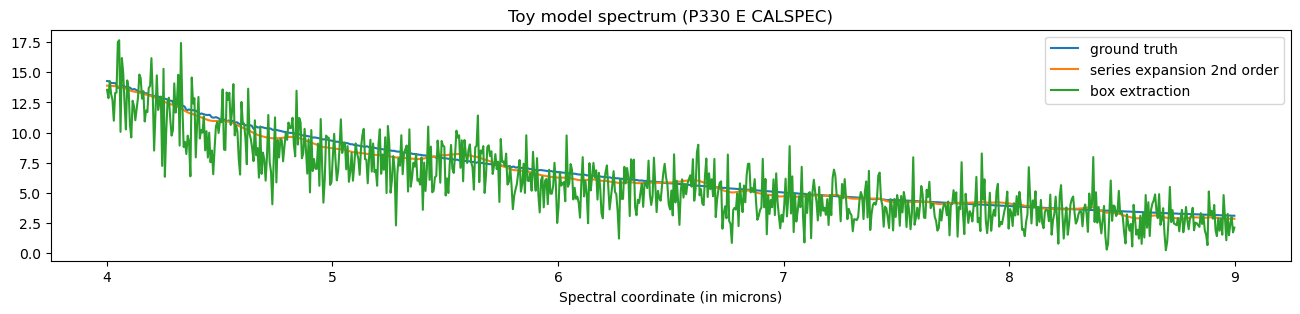

In [29]:
plot_fse1 = h_fse1(xx,8. *ones(length(xx)), λref=λmax)*h_fse1[:]
plot_fse2 = h_fse2(xx,8. *ones(length(xx)), λref=λmax)*h_fse2[:]
l_box_grid = range(λmin, stop=λmax, length=length(z_box))

fig, axs = PyPlot.subplots()
fig.set_size_inches(w=16, h=3)
axs.set_title("Toy model spectrum (P330 E CALSPEC)")
axs.plot(l_tm,z_tm, label="ground truth")
# axs.plot(l_tm,z_fpg, label="chromatic gaussian")
# axs.plot(l_tm,z_fpm, label="chromatic moffat")
# axs.plot(l_tm,z_fse1, label="series expansion 1st order")
axs.plot(l_tm,z_fse2, label="series expansion 2nd order")
axs.plot(l_box_grid, z_box, label="box extraction")
axs.set_xlabel("Spectral coordinate (in microns)")
axs.legend()
display(gcf())